# PC 3 : Apprentissage supervisé et prétraitement - 20 mai 2020 - Solution

Dans ce notebook, nous allons explorer quelques méthodes de prétraitement des données et leur impact sur une régression linéaire. 

Ce notebook vous permettra ainsi de découvrir des fonctionalités de `scikit-learn` permettant :
* d'entrainer et évaluer un algorithme d'apprentissage supervisé
* d'encoder des variables qualitatives ;
* de ramener des variables à une fourchette de valeurs ;
* de transformer des variables pour rapprocher leur distribution de celle d'une gaussienne.

## Librairies python 

Ce notebook a été créé avec les versions suivantes des librairies :
* numpy 1.18.3
* matplotlib 3.1.0
* pandas 1.0.3
* sklearn 0.23.0
* scipy 1.4.1

Des différences de version peuvent expliquer des comportements inattendus (avertissements, messages d'erreurs, fonctionalités inexistantes) mais il n'est pas nécessaire a priori d'avoir exactement les versions listées ci-dessus. 

Pour vérifier les versions des différentes librairies que vous utilisez, vous pouvez utiliser (après les import correspondant bien sûr) le code
```python
print(np.__version__)
print(matplotlib.__version__)
print(pd.__version__)
print(sklearn.__version__)
```

In [1]:
# charger numpy as np, matplotlib as plt
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

In [2]:
import pandas as pd

## 1. Données
Dans ce notebook nous allons travailler avec les données contenues dans le fichier `../../data/auto-mpg.tsv`. Ces données, obtenues sur https://archive.ics.uci.edu/ml/datasets/Auto+MPG, décrivent des voitures par les variables suivantes :

    1. mpg:           consommation (en miles par gallon), continue
    2. cylinders:     nombre de cylindres, discrète
    3. displacement:  cylindrée, continue
    4. horsepower:    chevaux-vapeur, continue
    5. weight:        poids, continue
    6. acceleration:  accélération, continue
    7. model year:    année, discrète
    8. origin:        région d'origine, discrète (1=Amérique du Nord ; 2=Europe ; 3=Asie)
    9. car name:      nom, chaîne de caractères.

Notre but va être de prédire la consommation d'un véhicule à partir des autres variables (à l'exclusion du nom de la voiture, qui est un identifiant unique).

In [13]:
# Charger les données
df = pd.read_csv("D:/Mines/1A/Data Science/sdd_2020/data/auto-mpg.tsv", delimiter='\t')

In [14]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### Création des matrices X et y de données

In [15]:
X = np.array(df.drop(columns=['mpg', 'car name']))

In [16]:
y = np.array(df['mpg'])

### Séparation en un jeu d'entraînement et un jeu de test

Notre but étant de construire un modèle prédictif, nous allons pour l'évaluer mettre de côté une partie des données (20%), le jeu de test, que nous n'utiliserons pas pour l'entraînement. Rappelez-vous que la minimisation du risque empirique ne garantit pas la minimisation du risque : la performance d'un modèle sur les données sur lesquelles il est entraîné peut être excellente, sans que celui-ci fasse de bonnes prédictions sur d'autres individus. Vous pouvez comparer ça à apprendre par cœur le jeu d'entraînement. Nous parlerons plus en détail de sélection et évaluation de modèle au chapitre 8. 

L'utilisation de l'argument `random_state` garantit que la répartition des individus entre les deux jeux soit toujours la même au sein de ce notebook si vous relancez la commande. Attention, vous n'aurez a priori pas la même que quelqu'un d'autre exécutant le même notebook sur une autre machine, ce qui peut expliquer de fluctuations entre vos résultats et ceux d'une autre personne.

In [17]:
from sklearn import model_selection

In [18]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.20, 
                                                                    random_state=27)

In [19]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(313, 7) (79, 7) (313,) (79,)


__Question :__ Combien d'observations et de variables contiennent, respectivement, le jeu d'échantillon et le jeu de test ?

__Réponse :__ Le jeu d'entraînement contient 313 échantillons. Le jeu de test en contient 79. Les données sont représentées par 7 variables.

## 2. Visualisation des données

Nous allons maintenant visualiser les variables représentant nos véhicules. Pour ce faire, nous allons séparer les variables continues (que nous allons représenter chacune par un histogramme) des variables discrètes (que nous allons représenter chacune par un diagramme en barre).

Nous nous concentrons sur le jeu d'entraînement : notre but est d'utiliser le jeu de test pour tester les modèles appris sur le jeu d'entraînement, en prétendant ne pas le connaître au moment de l'entraînement.

N'hésitez pas à ajuster les paramètres des méthodes de `matplotlib` pour produire des graphiques plus lisibles.

In [21]:
continuous_features = ['displacement', 'horsepower', 'weight', 'acceleration']
discrete_features = ['cylinders', 'model year', 'origin']

features = list(df.drop(columns=['mpg', 'car name']).columns)

continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features] #donne les numéro des lignes qui ont des continuous feaures
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]

print(continuous_features_idx)

[1, 2, 3, 4]


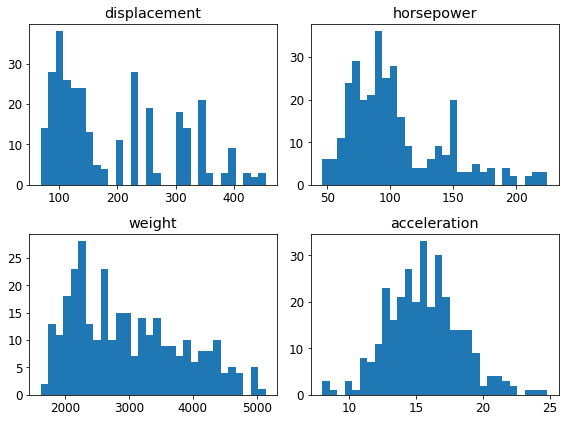

In [12]:
fig = plt.figure(figsize=(8, 6))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):
    # create a subplot in the (plot_idx+1) position of a 2x2 grid
    ax = fig.add_subplot(2, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h = ax.hist(X_train[:, feat_idx], bins=30, edgecolor='none')
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
# espacement entre les subplots
fig.tight_layout(pad=1.0)

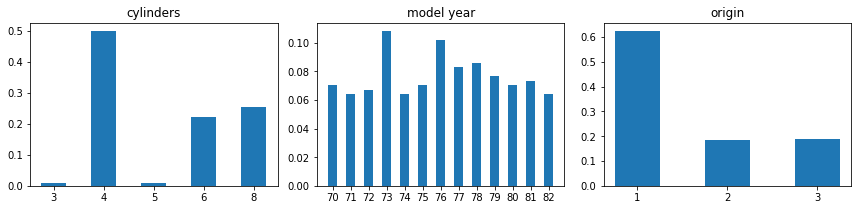

In [23]:
# Bar plots for discrete features
fig = plt.figure(figsize=(12, 3))

for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot in the (plot_idx+1) position of a 1x3 grid
    ax = fig.add_subplot(1, 3, (plot_idx+1))

    feature_values = np.unique(X_train[:, feat_idx])
    frequencies = [(float(len(np.where(X_train[:, feat_idx]==value)[0]))/X_train.shape[0]) \
                   for value in feature_values]
    
    b = ax.bar(range(len(feature_values)), frequencies, width=0.5, 
               tick_label=list([int(n) for n in feature_values]))
    
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
fig.tight_layout(pad=1.0)

__Question :__ Quelles sont les fourchettes de valeur prises par les différentes variables ?

__Réponse :__ Il s'agit ici d'observer que certaines valeurs ont des ordres de grandeur différents d'autres (poids vs accélération, année ou pays).

__Question :__ Tracer l'histogramme des étiquettes du jeu d'entrainement.

Text(0.5, 1.0, 'mpg')

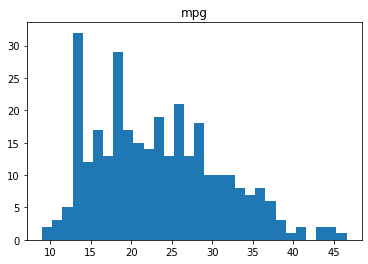

In [24]:
plt.hist(y_train, bins=30, edgecolor='none')
plt.title('mpg')

# 3. Un premier modèle

Nous allons maintenant construire une _baseline_, c'est-à-dire un premier modèle qui nous servira de point de comparaison. Ici, il s'agit d'utiliser `scikit-learn` pour entraîner une régression linéaire sur les données sans les prétraiter.

Les modèles linéaires de `scikit-learn` sont implémentés dans le module [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model). __N'hésitez pas à vous référer fréquemment à la documentation de scikit-learn, qui est très complète.__

In [25]:
from sklearn import linear_model

### Entraînement du modèle

In [26]:
# Initialisation d'un objet LinearRegression
predictor = linear_model.LinearRegression()

In [27]:
# Entrainement de cet objet sur les données d'entraînement
predictor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Prédiction sur les données de test

In [30]:
y_pred = predictor.predict(X_test)
print(y_pred)
print(y_test)

[26.36357468 22.27383583 20.25028261 25.39233643 31.98907585 23.87602886
 34.74539235 14.90435868 25.65943078 27.28593657 35.8574901  12.29402382
 19.59503338 30.5067229  11.69681012 20.14406869 29.72569769 28.70102601
 24.05588322 31.33893656 22.08606969 35.73936689 20.90612315 35.03595402
 26.60754206 11.3777562  15.90111076 29.0555394  27.51654017 32.2718959
 12.37453336 22.83314166 24.28439607 31.22331947 27.94530192 29.88213764
 10.63460286 20.92794296 35.90049105 12.13452066 22.62057818 20.89824128
 10.7420729  31.54845249 32.97632476 12.22698968  7.92090851 25.18125342
 10.12933636 28.09191196 11.83511292 26.24778038 31.26829074 34.7982559
 14.87983063 21.68464236 28.70605027 18.13786738 34.26935347 29.97209579
 13.61858412 18.08166455 14.79713039 30.81041706 21.05263161 28.08265687
 19.78736518 15.24979598 25.63264491 20.49859864 25.48524422 19.06256051
 23.32482553 35.96109124 19.85502885 15.12332114 14.80718491 29.13892189
 30.02400327]
[27.  24.  18.6 23.2 38.  28.  36.  16.

### Performance

Il s'agit maintenant d'évaluer ces prédictions. Pour cela, nous allons utiliser les fonctionalités du module [https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics](`metrics`) de `scikit-learn`.

Comme il s'agit d'un problème de régression, nous allons utiliser la __RMSE__ (_Root Mean Squared Error_) comme mesure de la performance du modèle : il s'agit de la racine carrée de la moyenne des carrés des erreurs.

__Question :__ Pourquoi prendre la racine carrée et pas simplement la MSE ?

__Réponse :__ Pour des questions d'homogénéité : la RMSE s'exprime dans la même unité que l'étiquette.

In [33]:
from sklearn import metrics

In [36]:
print("RMSE: %.2f" % sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE: 3.29


__Question :__ Que pensez-vous de cette erreur ? Est-elle faible? Grande ?

__Réponse :__ Vu la fourchette de valeurs des étiquettes (environ entre 10 et 45), une erreur de 3.29 n'est pas si mal.

Nous pouvons aussi utiliser une visualisation, et représenter chaque individu du jeu de test par son étiquette prédite vs. sa vraie étiquette.

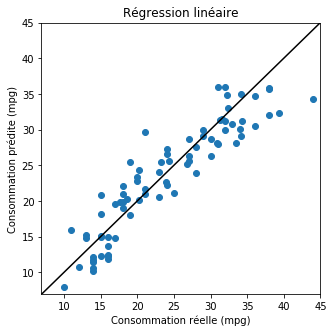

In [37]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred)

plt.xlabel("Consommation réelle (mpg)")
plt.ylabel("Consommation prédite (mpg)")
plt.title("Régression linéaire")

# Mêmes valeurs sur les deux axes
axis_min = np.min([np.min(y_test), np.min(y_pred)])-1
axis_max = np.max([np.max(y_test), np.max(y_pred)])+1
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)
  
# Diagonale y=x
plt.plot([axis_min, axis_max], [axis_min, axis_max], 'k-')

### Coefficients de régression

Pour comprendre notre modèle, nous pouvons regarder les coefficients affectés à chaque variable dans le modèle linéaire appris.

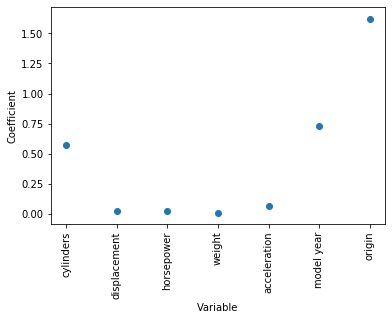

In [38]:
# Plot, for each feature, its coefficient in the model (here: absolute value)
num_features = X_train.shape[1]
feature_names = df.drop(columns=['mpg', 'car name']).columns
plt.scatter(range(num_features), np.abs(predictor.coef_))

plt.xlabel('Variable')
tmp = plt.xticks(range(num_features), feature_names, rotation=90)
tmp = plt.ylabel('Coefficient')

__Question :__ Quelle variable a le plus fort coefficient (en valeur absolue) ? Pensez-vous que cela signifie que cette variable joue un rôle très important dans la prédiction ?

__Réponse :__ C'est l'origine géographique de la voiture. Il ne faut pas oublier que les variables prennent des valeurs très différentes, `origin` a des valeurs entre 1 et 3 et `weight` entre 2000 et 5000... L'interprétation est difficile.

### 4. Encodage des variables qualitatives
La variable `origin` est une variable qualitative : l'encodage 1-2-3 est tout à fait arbitraire. Il suppose en particulier, si on réfléchit en termes de distances, que l'Asie est deux fois plus loin de l'Amérique du Nord que de l'Europe, ce qui n'a aucun sens.

Un encodage plus raisonnable pour ce genre de cas est ce qu'on appelle l'encodage _one-hot_, ou encore _dummy encoding_ : on représente la variable par autant de variables binaires qu'il y a de valeurs possibles (3 dans le cas de la variable `origin` : la première correspond à Amérique du Nord, la deuxième à Europe, la troisième à Asie), et on met à `1` la seule de ces variables binaires correspondant à la valeur que l'on encode.

Ainsi l'unique variable `origin` devient 3 variables binaires:
```    
   Amérique du Nord --> 1, 0, 0
   Europe --> 0, 1, 0
   Asie --> 0, 0, 1
```  
Cette représentation a l'inconvénient d'augmenter le nombre de variables, mais les distances euclidiennes sont maintenant plus raisonnables (elles valent 1 si les valeurs sont différentes et 0 si elles sont identiques).

Cette fonctionalité existe dans `pandas` comme dans `scikit-learn`. 

In [39]:
# Créer un nouveau data frame où la colomne 'origin' est remplacée par son encodage 'one-hot'
df_dummies = pd.get_dummies(df, columns=['origin'])

In [40]:
df_dummies.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,origin_1,origin_2,origin_3
0,18.0,8,307.0,130,3504,12.0,70,chevrolet chevelle malibu,1,0,0
1,15.0,8,350.0,165,3693,11.5,70,buick skylark 320,1,0,0
2,18.0,8,318.0,150,3436,11.0,70,plymouth satellite,1,0,0
3,16.0,8,304.0,150,3433,12.0,70,amc rebel sst,1,0,0
4,17.0,8,302.0,140,3449,10.5,70,ford torino,1,0,0


In [41]:
# Extraire de nouveau les données
X_dummies = np.array(df_dummies.drop(columns=['mpg', 'car name']))

In [42]:
X_dummies_train, X_dummies_test, y_d_train, y_d_test = model_selection.train_test_split(X_dummies, y, 
                                                                                        test_size=0.20, 
                                                                                        random_state=27)
                                                                                                    

Vous pouvez vérifier ici que l'utilisation de la même graine pour `random_state` génère la même répartition des données que précédemment :

In [43]:
np.sum(np.abs(y_d_train-y_train)) + np.sum(np.abs(y_d_test-y_test))

0.0

### Impact sur le modèle

Nous allons maintenant apprendre une régression linéaire sur les données où la variable `origin` a été remplacée par son encodage one-hot. 

__Question :__ Créer une instance `predictor_dummy` de la classe `LinearRegression` entraînée sur les données contenant la version _one-hot_ de la variable `origin`.

In [44]:
# Créer un nouvel objet LinearRegression 
predictor_dummy = linear_model.LinearRegression()

# Entraîner predictor_dummy sur les nouvelles données
predictor_dummy.fit(X_dummies_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

__Question :__ Créer un array `y_pred_dummy` qui contient les prédictions de la nouvelle régression linéaire sur les données de test.

In [45]:
y_pred_dummy = predictor_dummy.predict(X_dummies_test)

__Question :__ Quelle est la RMSE, sur le jeu de test, de ce nouveau modèle ? La comparer à la RMSE précédente.

In [47]:
print("RMSE (encodage one-hot): %.2f" % sqrt(metrics.mean_squared_error(y_test, y_pred_dummy)))

RMSE (encodage one-hot): 3.25


__Réponse :__ La RMSE est un tout petit peu plus faible.

### Comparaison aux prédictions de la baseline

Les performances sont-elles vraiment différentes ? Nous pouvons comparer les prédictions directement.

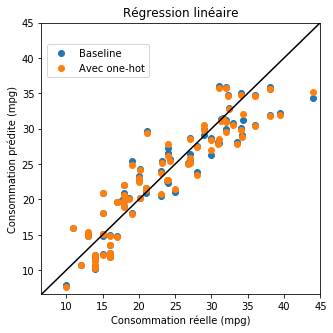

In [48]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, label='Baseline')
plt.scatter(y_test, y_pred_dummy, label='Avec one-hot')

plt.xlabel("Consommation réelle (mpg)")
plt.ylabel("Consommation prédite (mpg)")
plt.title("Régression linéaire")

# Mêmes valeurs sur les deux axes
axis_min = np.min([np.min(y_test), np.min(y_pred), np.min(y_pred_dummy)])-1
axis_max = np.max([np.max(y_test), np.max(y_pred), np.max(y_pred_dummy)])+1
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)
  
# Diagonale y=x
plt.plot([axis_min, axis_max], [axis_min, axis_max], 'k-')

plt.legend(loc=(0.02, 0.8))

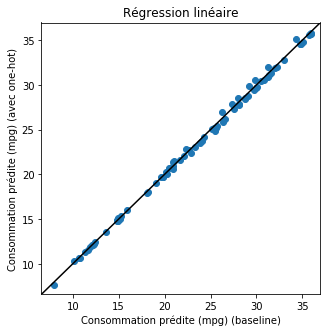

In [49]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(y_pred, y_pred_dummy)

plt.xlabel("Consommation prédite (mpg) (baseline)")
plt.ylabel("Consommation prédite (mpg) (avec one-hot)")
plt.title("Régression linéaire")

# Mêmes valeurs sur les deux axes
axis_min = np.min([np.min(y_pred), np.min(y_pred_dummy)])-1
axis_max = np.max([np.max(y_pred), np.max(y_pred_dummy)])+1
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)
  
# Diagonale y=x
plt.plot([axis_min, axis_max], [axis_min, axis_max], 'k-')

In [50]:
import scipy.stats as st

In [51]:
r, pval = st.pearsonr(y_pred, y_pred_dummy)
print("Corrélation entre les prédictions : %.2f (p=%.2e)" % (r, pval))

Corrélation entre les prédictions : 1.00 (p=1.79e-108)


### Coefficients de régression

Comparons maintenant les deux modèles visuellement :

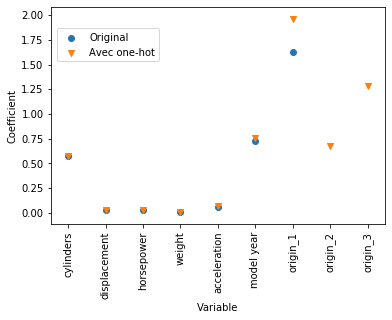

In [52]:
# Plot, for each feature, its coefficient in the model (here: absolute value)
num_features = X_train.shape[1]
plt.scatter(range(num_features), np.abs(predictor.coef_), label='Original')

num_features2 = X_dummies_train.shape[1]
plt.scatter(range(num_features2), np.abs(predictor_dummy.coef_), label='Avec one-hot', marker='v')
feature_names2 = df_dummies.drop(columns=['mpg', 'car name']).columns

plt.xlabel('Variable')
tmp = plt.xticks(range(num_features2), feature_names2, rotation=90)
tmp = plt.ylabel('Coefficient')

plt.legend(loc=(0.02, 0.75))

__Question :__ Ce modèle est-il vraiment différent du précédent ?

__Réponse :__ La contribution de chaque origine au modèle précédent est :
```
    Amérique du Nord : predictor.coef_[-1] ~ 1.62
    Europe : 1.62 x 2 ~ 3.24
    Asie : 1.62 x 3 ~ 4.86
```
Pour le nouveau modèle :
```
    Amérique du Nord : predictor_dummy.coef_[-3] ~ -1.95
    Europe : predictor_dummy.coef_[-2] ~ 0.68
    Asie : predictor_dummy.coef_[-1] ~ 1.28
```
Les autres coefficients ne changent pas.

Les modèles sont très légèrements différents mais cette différence a peu d'impact. __Ça ne veut pas dire que cette transformation n'a jamais d'intérêt en général...__    

## 5. Ramener les variables à des échelles comparables

Le fait que les variables soient sur des échelles différentes rend l'interprétation des coefficients de la régression linéaire délicate. 

### 5.1 Centrer et réduire les variables

Centrer et réduire les variables (comme nous l'avons vu dans la PC2) permet de remédier à ce problème.

#### Transformation des variables

In [53]:
from sklearn import preprocessing

In [54]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [55]:
X_train_scaled = standard_scaler.transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

#### Visualisation des nouvelles variables

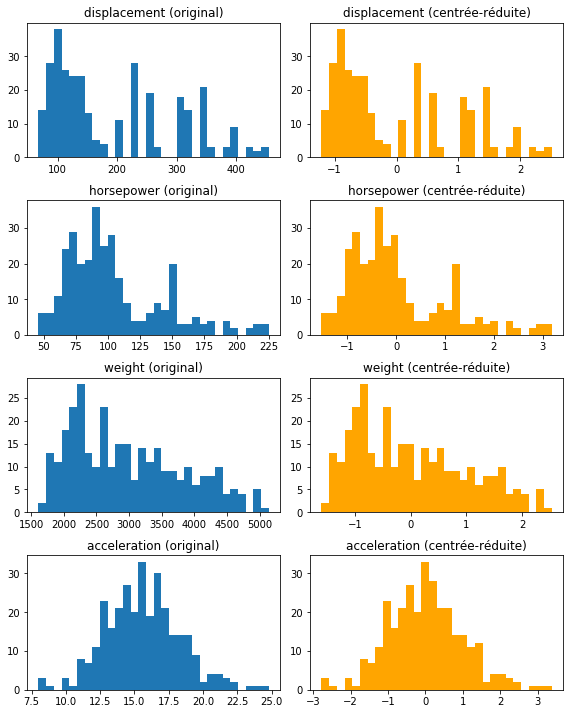

In [56]:
fig = plt.figure(figsize=(8, 10))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):
    # create subplot
    ax = fig.add_subplot(4, 2, (2*plot_idx+1))
    # plot the original histogram of feat_idx
    h = ax.hist(X_train[:, feat_idx], bins=30, edgecolor='none')
    # use the name of the feature as a title for each histogram
    ax.set_title("%s (original)" % features[feat_idx])    
    
    # create subplot
    ax = fig.add_subplot(4, 2, (2*plot_idx+2))
    # plot the new histogram of feat_idx
    h = ax.hist(X_train_scaled[:, feat_idx], bins=30, edgecolor='none', color='orange')
    # use the name of the feature as a title for each histogram
    ax.set_title("%s (centrée-réduite)" % features[feat_idx])
    
# espacement entre les subplots
fig.tight_layout(pad=1.0)

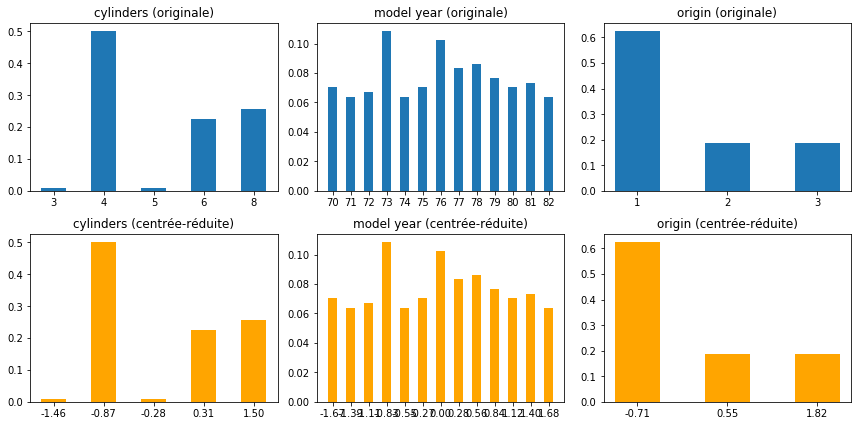

In [57]:
# Bar plots for discrete features
fig = plt.figure(figsize=(12, 6))

# Original features
for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot
    ax = fig.add_subplot(2, 3, (plot_idx+1))
    # create bar plot
    feature_values = np.unique(X_train[:, feat_idx])
    frequencies = [(float(len(np.where(X_train[:, feat_idx]==value)[0]))/X_train.shape[0]) \
                   for value in feature_values]
    tick_labels = feature_values.astype(int)
    b = ax.bar(range(len(feature_values)), frequencies, width=0.5, tick_label=tick_labels)    
    # use the name of the feature as a title for each histogram
    ax.set_title("%s (originale)" % features[feat_idx])

# Transformed features
for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot
    ax = fig.add_subplot(2, 3, (3+plot_idx+1))
    # create bar plot
    feature_values = np.unique(X_train_scaled[:, feat_idx])
    frequencies = [(float(len(np.where(X_train_scaled[:, feat_idx]==value)[0]))/X_train_scaled.shape[0]) \
                   for value in feature_values]
    tick_labels = ["%.2f" % v for v in feature_values]
    b = ax.bar(range(len(feature_values)), frequencies, width=0.5, 
               tick_label=tick_labels, color='orange')    
    # use the name of the feature as a title for each histogram
    ax.set_title("%s (centrée-réduite)" % features[feat_idx])
fig.tight_layout(pad=1.0)

#### Impact sur le modèle

__Question :__ Entrainez un modèle `predictor_scaled` sur les données centrées-réduites.

In [58]:
# Créer un nouvel objet LinearRegression 
predictor_scaled = linear_model.LinearRegression()

# Entraîner predictor_dummy sur les nouvelles données
predictor_scaled.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

__Question :__ Créer un array `y_pred_scaled` qui contient les prédictions de `predictor_scaled` sur le jeu de test.

In [59]:
y_pred_scaled = predictor_scaled.predict(X_test_scaled)

__Question :__ Quelle est la RMSE, sur le jeu de test, de ce nouveau modèle ? La comparer à la RMSE précédente.

In [62]:
print("RMSE (scaled): %.2f" % sqrt(metrics.mean_squared_error(y_test, y_pred_scaled)))

RMSE (scaled): 3.29


__Réponse :__ La RMSE n'a pas changé.

__Question :__ Comparer les coefficients de régression des deux modèles. Quelles sont les variables les plus pertinentes pour prédire la consommation d'un véhicule ?

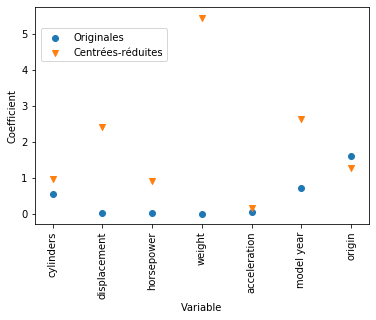

In [63]:
# Plot, for each feature, its coefficient in the model (here: absolute value)
num_features = X_train.shape[1]
plt.scatter(range(num_features), np.abs(predictor.coef_), label='Originales')

plt.scatter(range(num_features), np.abs(predictor_scaled.coef_), label='Centrées-réduites', marker='v')

plt.xlabel('Variable')
tmp = plt.xticks(range(num_features), feature_names, rotation=90)
tmp = plt.ylabel('Coefficient')
plt.legend(loc=(0.02, 0.75))

__Réponse :__ On peut maintenant interpréter les coefficients de régression : les variables les plus importantes sont le poids, l'année et la cylindrée. On voit que l'origine est beaucoup moins pertinente qu'on aurait pu le croire.

__Remarque :__ Réfléchir au fait que les prédictions sont exactement les mêmes mais pas les coefficients.

### 5.2 [Pour aller plus loin] Réduction min-max
La réduction min-max est une autre façon de ramener les variables sur une même échelle, en les ramenant entre 0 et 1 par $x_j \leftarrow (x_j - \max(x_j))/(\max(x_j)-\min(x_j))$.

Dans `scikit-learn`, elle est implémentée de manière très simimlaire à `StandardScaler` dans `preprocessing.MinMaxScaler()`. 

__Question :__ Reproduisez l'analyse de la section 5.1 avec cette nouvelle transformation des données. Les résultats sont-ils différents de la section 5.1 ?

#### Transformation des variables

In [45]:
minmax_scaler = preprocessing.MinMaxScaler()
minmax_scaler.fit(X_train)

MinMaxScaler()

In [46]:
X_train_minmax = minmax_scaler.transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

#### Visualisation des variables

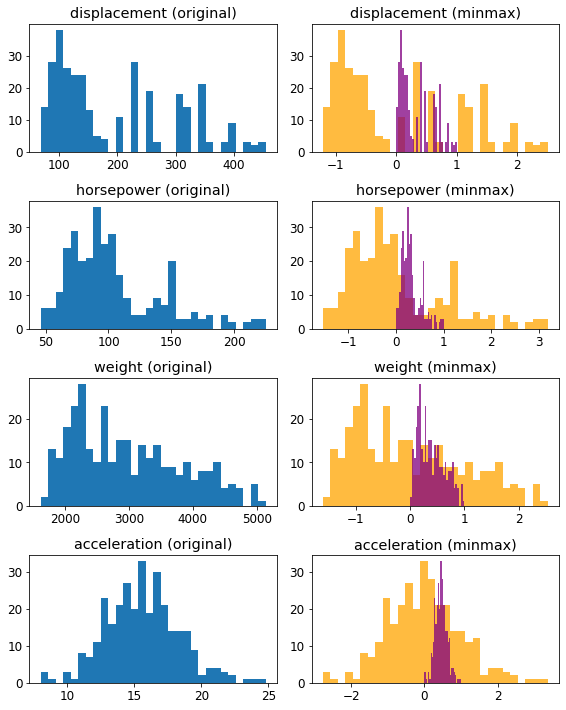

In [47]:
fig = plt.figure(figsize=(8, 10))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):
    # create subplot
    ax = fig.add_subplot(4, 2, (2*plot_idx+1))
    # plot the original histogram of feat_idx
    h = ax.hist(X_train[:, feat_idx], bins=30, edgecolor='none')
    # use the name of the feature as a title for each histogram
    ax.set_title("%s (original)" % features[feat_idx])    
    
    # create subplot
    ax = fig.add_subplot(4, 2, (2*plot_idx+2))
    # plot the new histogram of feat_idx
    h = ax.hist(X_train_scaled[:, feat_idx], bins=30, edgecolor='none', color='orange', alpha=0.75)
    # use the name of the feature as a title for each histogram
    ax.set_title("%s (centrée-réduite)" % features[feat_idx])
    
    # plot the new histogram of feat_idx
    h = ax.hist(X_train_minmax[:, feat_idx], bins=30, edgecolor='none', color='purple', alpha=0.75)
    # use the name of the feature as a title for each histogram
    ax.set_title("%s (minmax)" % features[feat_idx])
    
# espacement entre les subplots
fig.tight_layout(pad=1.0)

#### Impact sur le modèle

In [48]:
# Créer un nouvel objet LinearRegression 
predictor_minmax = linear_model.LinearRegression()

# Entraîner predictor_dummy sur les nouvelles données
predictor_minmax.fit(X_train_minmax, y_train)

LinearRegression()

In [49]:
y_pred_minmax = predictor_minmax.predict(X_test_minmax)

In [50]:
print("RMSE (scaled): %.2f" % metrics.mean_squared_error(y_test, y_pred_minmax, squared=False))

RMSE (scaled): 3.29


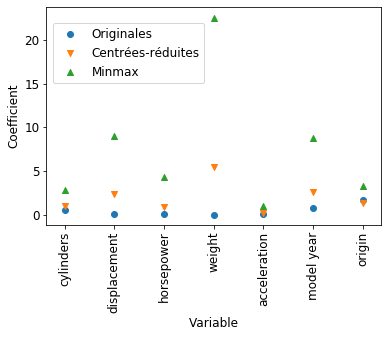

In [51]:
# Plot, for each feature, its coefficient in the model (here: absolute value)
num_features = X_train.shape[1]
plt.scatter(range(num_features), np.abs(predictor.coef_), label='Originales')

plt.scatter(range(num_features), np.abs(predictor_scaled.coef_), label='Centrées-réduites', marker='v')
plt.scatter(range(num_features), np.abs(predictor_minmax.coef_), label='Minmax', marker='^')

plt.xlabel('Variable')
tmp = plt.xticks(range(num_features), feature_names, rotation=90)
tmp = plt.ylabel('Coefficient')
plt.legend(loc=(0.02, 0.65))

__Interprétation :__ Toujours le même modèle prédictif, les poids changent car les fourchettes ne sont pas les mêmes mais l'importante respective des variables est intouchée.

## 6. [Pour aller plus loin] Normalisation des variables

Vous l'aurez remarqué en regardant les histogrammes : nos variables continues ne semblent pas suivre une distribution normale. 

Dans le cas de la régression linéaire, nous n'avons fait aucune hypothèse sur la normalité des variables : nous avons supposés que les résidus sont normalement distribués. Cependant, transformer les variables pour les rapprocher de gaussiennes peut permettre d'améliorer les modèles, en particulier en contrôlant l'[asymmétrie](https://fr.wikipedia.org/wiki/Asym%C3%A9trie_(statistiques)) des valeurs. 

`scikit-learn` permet d'appliquer deux types de transformations normales des variables : 
* la transformation Box-Cox, qui ne s'applique qu'à des variables non nulles positives. C'est cette première que nous allons illustrer ici.
* la transformation de Yeo-Johnson.
Ces deux méthodes sont disponibles dans la classe [`sklearn.preprocessing.PowerTransformer`](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-transformer) et vous pouvez en lire plus à leur sujet dans [la doc](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-transformer).

__Remarque pour aller plus loin:__ Un histogramme n'est pas un très bon moyen de vérifier qu'une distribution empirique correspond à une distribution théorique. On leur préfère plutôt un [graphe quantile-quantile (QQ-plot)](https://fr.wikipedia.org/wiki/Diagramme_quantile-quantile) ou... un test statistique (pour la normalité, on utilise par exemple le [test de Shapiro-Wilk](https://fr.wikipedia.org/wiki/Test_de_Shapiro-Wilk) ou le [test de Kolmogorov-Smirnov](https://fr.wikipedia.org/wiki/Test_de_Kolmogorov-Smirnov). 

### Transformation Box-Cox des variables

In [52]:
boxcox_scaler = preprocessing.PowerTransformer(method='box-cox')
boxcox_scaler.fit(X_train)

PowerTransformer(method='box-cox')

In [53]:
X_train_boxcox = boxcox_scaler.transform(X_train)
X_test_boxcox = boxcox_scaler.transform(X_test)

### Visualisation des variables

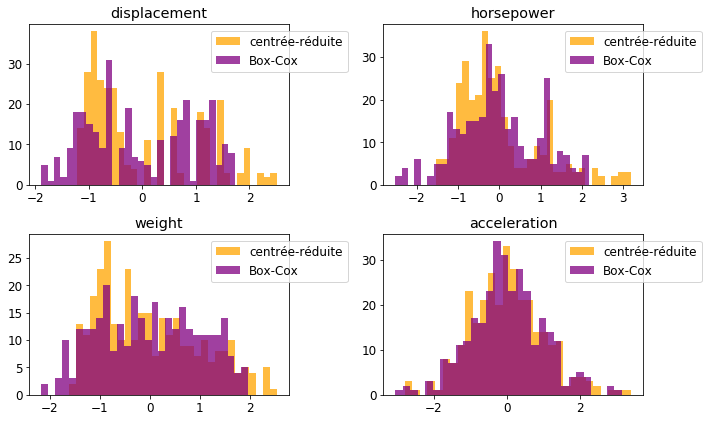

In [54]:
fig = plt.figure(figsize=(10, 6))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx): 
    # create subplot
    ax = fig.add_subplot(2, 2, (plot_idx+1))
    # plot the new histogram of feat_idx
    h = ax.hist(X_train_scaled[:, feat_idx], bins=30, edgecolor='none', color='orange', alpha=0.75, 
               label='centrée-réduite')
    
    # plot the new histogram of feat_idx
    h = ax.hist(X_train_boxcox[:, feat_idx], bins=30, edgecolor='none', color='purple', alpha=0.75,
               label='Box-Cox')
    
    # use the name of the feature as a title for each histogram
    ax.set_title("%s" % features[feat_idx])
    
    ax.legend(loc=(0.7, 0.7))
    
# espacement entre les subplots
fig.tight_layout(pad=1.0)

### Impact sur le modèle

__Question :__ Quel est l'impact de cette transformation sur le modèle ? 

In [55]:
# Créer un nouvel objet LinearRegression 
predictor_boxcox = linear_model.LinearRegression()

# Entraîner predictor4 sur les nouvelles données
predictor_boxcox.fit(X_train_boxcox, y_train)

LinearRegression()

In [56]:
y_pred_boxcox = predictor_boxcox.predict(X_test_boxcox)

In [57]:
print("RMSE (scaled): %.2f" % metrics.mean_squared_error(y_test, y_pred_boxcox, squared=False))

RMSE (scaled): 3.01


La performance s'est améliorée !

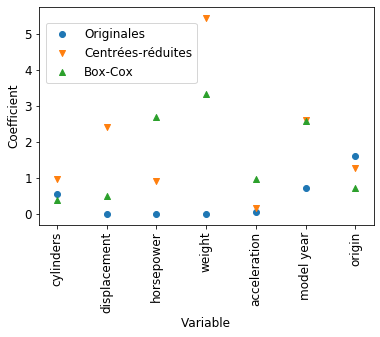

In [58]:
# Plot, for each feature, its coefficient in the model (here: absolute value)
num_features = X_train.shape[1]
plt.scatter(range(num_features), np.abs(predictor.coef_), label='Originales')

plt.scatter(range(num_features), np.abs(predictor_scaled.coef_), label='Centrées-réduites', marker='v')
plt.scatter(range(num_features), np.abs(predictor_boxcox.coef_), label='Box-Cox', marker='^')

plt.xlabel('Variable')
tmp = plt.xticks(range(num_features), feature_names, rotation=90)
tmp = plt.ylabel('Coefficient')
plt.legend(loc=(0.02, 0.65))

En utilisant la transformation Box-Cox, on donne maintenant plus d'importance à l'accélération et aux CV, et moins au poids du véhicule.

#### Comparaison aux prédictions de la baseline

Nous pouvons aussi comparer les prédictions faites par ce nouveau modèles à celles de la _baseline_ :

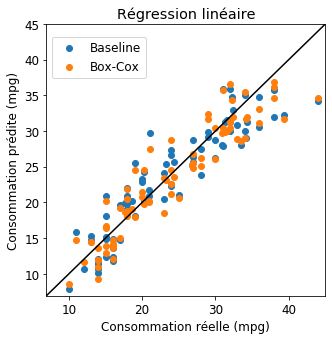

In [59]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, label='Baseline')
plt.scatter(y_test, y_pred_boxcox, label='Box-Cox')

plt.xlabel("Consommation réelle (mpg)")
plt.ylabel("Consommation prédite (mpg)")
plt.title("Régression linéaire")

# Mêmes valeurs sur les deux axes
axis_min = np.min([np.min(y_test), np.min(y_pred), np.min(y_pred_boxcox)])-1
axis_max = np.max([np.max(y_test), np.max(y_pred), np.max(y_pred_boxcox)])+1
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)
  
# Diagonale y=x
plt.plot([axis_min, axis_max], [axis_min, axis_max], 'k-')

plt.legend(loc=(0.02, 0.8))

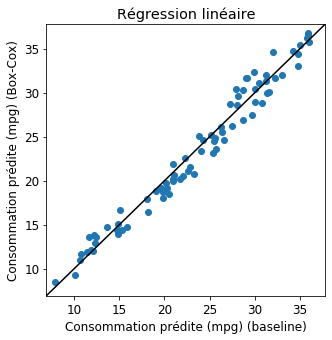

In [60]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(y_pred, y_pred_boxcox)

plt.xlabel("Consommation prédite (mpg) (baseline)")
plt.ylabel("Consommation prédite (mpg) (Box-Cox)")
plt.title("Régression linéaire")

# Mêmes valeurs sur les deux axes
axis_min = np.min([np.min(y_pred), np.min(y_pred_boxcox)])-1
axis_max = np.max([np.max(y_pred), np.max(y_pred_boxcox)])+1
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)
  
# Diagonale y=x
plt.plot([axis_min, axis_max], [axis_min, axis_max], 'k-')

In [61]:
import scipy.stats as st

In [62]:
r, pval = st.pearsonr(y_pred, y_pred_boxcox)
print("Corrélation entre les prédictions : %.2f (p=%.2e)" % (r, pval))

Corrélation entre les prédictions : 0.99 (p=1.66e-61)


__Remarque :__ Les prédictions sont très corrélées avec celles obtenues avec la deuxième transformation : le modèle est différent et sa performance semble meilleure, mais cette différence n'est peut-être pas significative.

## 7. Pour aller encore plus loin

Le pré-traitement des données est une partie importante du travail de _data scientist_. Voici quelques ressources et remarques pour aller plus loin :
* La transformation en vecteurs de données non-structurées (telles que texte ou images) est possible à travers des techniques telles que :
  * pour le texte : les approches bag-of-word ou tf-idf (voir [la doc scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-extraction) ou [le cours OpenClassrooms Analysez vos données textuelles](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles);
  * pour les images : les approches telles que SIFT (voir [le cours OpenClassrooms Classez et segmentez des données visuelles](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles).
  
* Les méthodes à noyaux et l'apprentissage profond, que nous aborderons brièvement à la fin de ce cours, permettent d'aborder autrement la représentation de données non-structurées.

* https://github.com/mirekphd/awesome-feature-engineering
* https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/